In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import root
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Data Preprocessing

In this section, we process and select the data we need.

In [2]:
ISIN_list = ["CA135087K528", "CA135087K940", "CA135087L518", "CA135087L930", "CA135087M847",
             "CA135087N837", "CA135087P576", "CA135087Q491", "CA135087Q988", "CA135087R895"]

date_list = [datetime(2025, 1, 6), datetime(2025, 1, 7), datetime(2025, 1, 8), datetime(2025, 1, 9), datetime(2025, 1, 10),
             datetime(2025, 1, 13), datetime(2025, 1, 14), datetime(2025, 1, 15), datetime(2025, 1, 16), datetime(2025, 1, 17)]

In [3]:
df_dct = {}
for dt in date_list:
    df = pd.read_csv(f"./{dt.strftime('%Y-%m-%d')} bond yield.csv")
    df = df[df["ISIN"].isin(ISIN_list)].drop_duplicates()
    df["issue date"] = pd.to_datetime(df["issue date"])
    df["maturity date"] = pd.to_datetime(df["maturity date"])
    df["coupon"] = df["coupon"].str.rstrip('%').astype(float) / 100
    df = df.sort_values(["maturity date"], ascending=True, inplace=False).reset_index(drop=True)
    df_dct[dt] = df

## Curve Bootstrapping

In this section, we construct different curves.

First, we define `Curve` class to store output.

In [4]:
class Curve:
    dates: list[datetime]
    rates: list[float]
    valuation_date: datetime

    def __init__(self, valuation_date: datetime) -> None:
        self.valuation_date = valuation_date
        self.dates = []
        self.rates = []

    def add_data(self, date: datetime, rate: float) -> None:
        """This assumes dates is larger than the last available date."""
        if len(self.dates) > 0 and date <= self.dates[-1]:
            raise ValueError('Date should be larger than the last available date')

        self.dates.append(date)
        self.rates.append(rate)

    def get_yield(self, date: datetime) -> float:
        """Return linear interpolation between dates."""
        if len(self.dates) == 0:
            return 0.0
        if date in self.dates:
            return self.rates[self.dates.index(date)]
        else:
            dates_timestamps = [date.timestamp() for date in self.dates]
            return float(np.interp(date.timestamp(), dates_timestamps, self.rates))

    def __str__(self) -> str:
        return self.valuation_date.strftime('%Y-%m-%d')

    def get_curve(self) -> tuple[list[datetime], list[float]]:
        return self.dates, self.rates

Then we define the  `cashflow()` function that generate the cashflow of a bond except for the maturity cashflow.

In [5]:
PRINCIPAL = 100

def cashflow(valuation_date: datetime, maturity_date: datetime,
             coupon: float) -> dict[datetime, float]:
    """This function outputs the cashflow of a bond.
     Note that the bond delivers coupon in semi-annual basis.
     """
    cashflow_dct = {}
    curr_date = maturity_date
    while curr_date >= valuation_date:
        prev_date = curr_date - relativedelta(months=6)
        dt_diff = (curr_date - prev_date).days
        cashflow_dct[curr_date] = coupon * PRINCIPAL * 0.5 * min(dt_diff, (curr_date - valuation_date).days) / dt_diff
        curr_date = prev_date
    cashflow_dct[maturity_date] += PRINCIPAL
    return cashflow_dct

### Yield Curve

We bootstrap each day's yield curve and plot them.

In [6]:
def bootstrap_yield_curve(bonds: pd.DataFrame, valuation_date: datetime) -> Curve:
    curve = Curve(valuation_date)

    for bond in bonds.iterrows():
        maturity = bond[1]["maturity date"]
        coupon = bond[1]["coupon"]
        price = bond[1]["price"]
        cashflow_dct = cashflow(valuation_date, maturity, coupon)

        # construct the PV function
        def present_value(ytm: float) -> float:
            """Present Value of a bond given YTM."""
            pv = price
            for dt, money in cashflow_dct.items():
                pv -= money * np.exp(-ytm * (dt - valuation_date).days / 365)
            return pv

        def duration(ytm: float) -> float:
            """Duration of a bond, given YTM. This is the derivative of present_value()."""
            dr = 0
            for dt, money in cashflow_dct.items():
                t = (dt - valuation_date).days / 365
                dr += t * money * np.exp(-ytm * t)
            return dr
        
        # calculate rates
        new_rate = root(fun=present_value, x0=coupon, jac=duration).x.item()

        # add to curve
        curve.add_data(maturity, new_rate)

    # return
    return curve

In [7]:
yield_curve_dct = {}
for dt in date_list:
    curve = bootstrap_yield_curve(df_dct[dt], dt)
    yield_curve_dct[dt] = curve

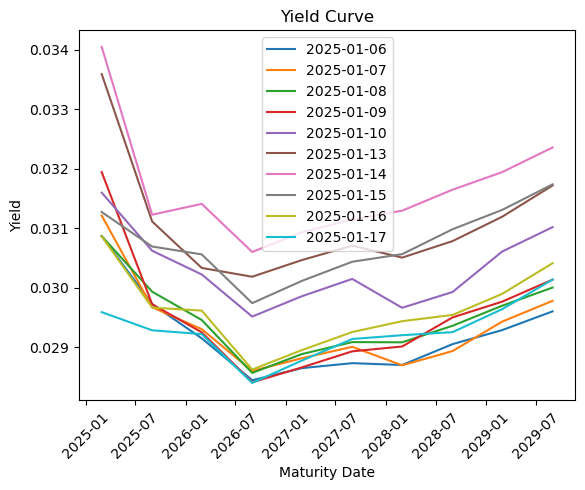

In [8]:
plt.figure()
for dt in date_list:
    curve = yield_curve_dct[dt]
    plt.plot(curve.dates, curve.rates, label=str(curve))
plt.xticks(rotation=45)
plt.xlabel('Maturity Date')
plt.ylabel('Yield')
plt.title("Yield Curve")
plt.legend()
plt.show()

In [27]:
# curve = yield_curve_dct[date_list[0]]
# dates_numeric = [(dt - date_list[0]).days / 365 for dt in curve.dates]
# 
# from scipy import interpolate
# f = interpolate.interp1d(dates_numeric, curve.rates, bounds_error=False, fill_value=(curve.rates[0], curve.rates[-1]))
# dt_full = np.linspace(0, 10, 10001)
# r_full = f(dt_full)

In [28]:
# pd.DataFrame({"dt": dt_full, "r": r_full}).to_csv("./A2/risk-free-rate.csv", index=False)

We then process the csv file and compute the yield curve.

### Spot Curve

Now we compute and plot spot curve.

In [9]:
def bootstrap_spot_curve(bonds: pd.DataFrame, valuation_date: datetime) -> Curve:
    curve = Curve(valuation_date)

    for bond in bonds.iterrows():
        maturity = bond[1]["maturity date"]
        coupon = bond[1]["coupon"]
        price = bond[1]["price"]
        cashflow_dct = cashflow(valuation_date, maturity, coupon)

        # get rid of coupon payments that can be discounted
        dcf = 0
        for dt, money in cashflow_dct.items():
            if dt != maturity:
                rate = curve.get_yield(dt)
                dcf += money * np.exp(-rate * (dt - valuation_date).days / 365)

        # after discounting all dcf, derive the rate
        new_rate = float(np.log(cashflow_dct[maturity] / (price - dcf)) / ((maturity - valuation_date).days / 365))

        # add to curve
        curve.add_data(maturity, new_rate)

    # return
    return curve

In [10]:
spot_curve_dct = {}
for dt in date_list:
    curve = bootstrap_spot_curve(df_dct[dt], dt)
    spot_curve_dct[dt] = curve

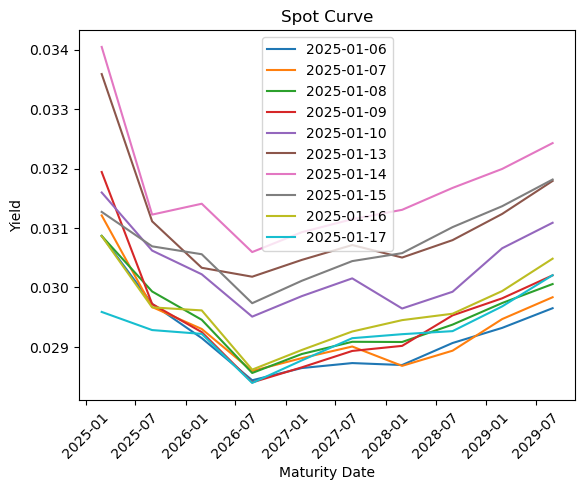

In [11]:
plt.figure()
for dt in date_list:
    curve = spot_curve_dct[dt]
    plt.plot(curve.dates, curve.rates, label=str(curve))
plt.xticks(rotation=45)
plt.xlabel('Maturity Date')
plt.ylabel('Yield')
plt.title('Spot Curve')
plt.legend()
plt.show()

### Forward Curve

In [12]:
class ForwardCurve(Curve):
    forward_date: datetime
    spot_curve: Curve
    forward_spot_rate: float
    forward_date_diff: float
    
    def __init__(self, valuation_date: datetime, forward_date: datetime, spotCurve: Curve) -> None:
        super().__init__(valuation_date)
        self.forward_date = forward_date
        self.spot_curve = spotCurve
        # store rate at forward date
        self.forward_spot_rate = spotCurve.get_yield(forward_date)
        # store difference in years between forward date and valuation date
        self.forward_date_diff = (forward_date - valuation_date).days / 365
   
    def get_yield(self, date: datetime) -> float:
        n = (date - self.forward_date).days / 365
        if n == 0:
            return self.forward_spot_rate
        t = self.forward_date_diff
        return (self.spot_curve.get_yield(date) * (t + n) - self.forward_spot_rate * t) / n
    
    def __str__(self):
        return self.valuation_date.strftime('%Y-%m-%d')

In [13]:
def bootstrap_forward_curve(spotCurve: Curve) -> ForwardCurve:
    """This compute the one-year forward curve."""
    return ForwardCurve(spotCurve.valuation_date, spotCurve.valuation_date + relativedelta(years=1), spotCurve)

In [14]:
forward_curve_dct = {}
for dt in date_list:
    curve = bootstrap_forward_curve(spot_curve_dct[dt])
    forward_curve_dct[dt] = curve

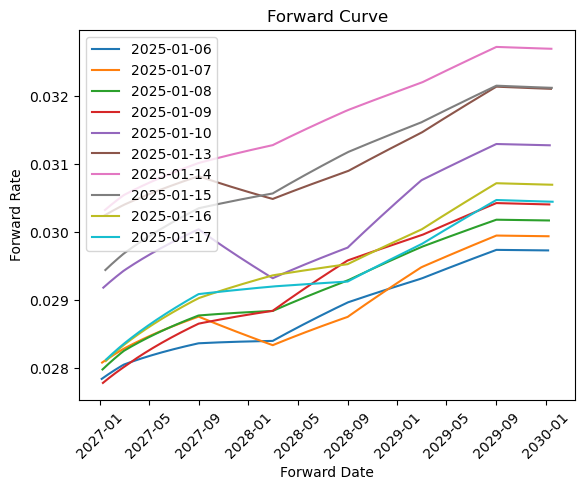

In [15]:
plt.figure()
for dt in date_list:
    dt_list = []
    forward_curve = forward_curve_dct[dt]
    curr_dt = forward_curve.forward_date + relativedelta(years=1)
    while curr_dt <= forward_curve.forward_date + relativedelta(years=4):
        dt_list.append(curr_dt)
        curr_dt += relativedelta(days=1)
    yield_lst = [forward_curve.get_yield(dt) for dt in dt_list]
    # plot
    plt.plot(dt_list, yield_lst, label=str(forward_curve))

plt.xticks(rotation=45)
plt.xlabel('Forward Date')
plt.ylabel('Forward Rate')
plt.title('Forward Curve')
plt.legend()
plt.show()

### Test

In [16]:
bonds = pd.DataFrame({
    "maturity date": [datetime(2020, 1, 1), datetime(2020, 7, 1), datetime(2021, 1, 1)],
    "coupon": [0.0, 0.0, 0.0],
    "price": [100 / (1 + 0.01) ** 0.5, 100 / (1 + 0.03), 100 / (1 + 0.02) ** 1.5],
})

curve = bootstrap_spot_curve(bonds, datetime(2019, 7, 1))

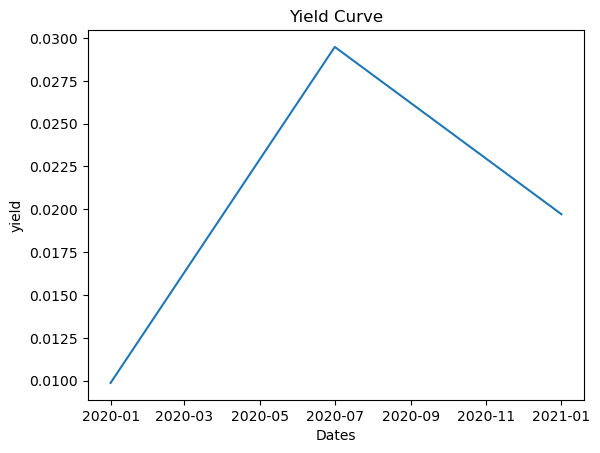

In [17]:
dt_list = []
dt = curve.dates[0]
while dt <= curve.dates[-1]:
    dt_list.append(dt)
    dt += relativedelta(days=1)
yield_lst = [curve.get_yield(dt) for dt in dt_list]

plt.figure()
plt.plot(dt_list, yield_lst)
plt.xlabel("Dates")
plt.ylabel("yield")
plt.title("Yield Curve")
plt.show()

## Covariance Matrix Analysis

First Calculate forward rate at 0, 1, 2, 3, 4 years ahead.

In [18]:
# first calculate the forward rate at the specific years
forward_rate_list = []
for dt in date_list:
    curve = forward_curve_dct[dt]
    forward_rate_list_single_curve = []
    for i in range(1, 5):
        forward_rate_list_single_curve.append(curve.get_yield(curve.valuation_date + relativedelta(years=i)))
    forward_rate_list.append(forward_rate_list_single_curve)

yield_rate_list = []
for dt in date_list:
    curve = yield_curve_dct[dt]
    yield_rate_single_curve = []
    for i in range(1, 5):
        yield_rate_single_curve.append(curve.get_yield(curve.valuation_date + relativedelta(years=i)))
    yield_rate_list.append(yield_rate_single_curve)

Then compute the covariance matrix.

In [19]:
forward_rate_array = np.array(forward_rate_list)
forward_rate_array_diff = np.diff(forward_rate_array, axis=0)
forward_cov_matrix = np.cov(forward_rate_array_diff.T)

yield_rate_array = np.array(yield_rate_list)
yield_rate_array_diff = np.diff(yield_rate_array, axis=0)
yield_cov_matrix = np.cov(yield_rate_array_diff.T)

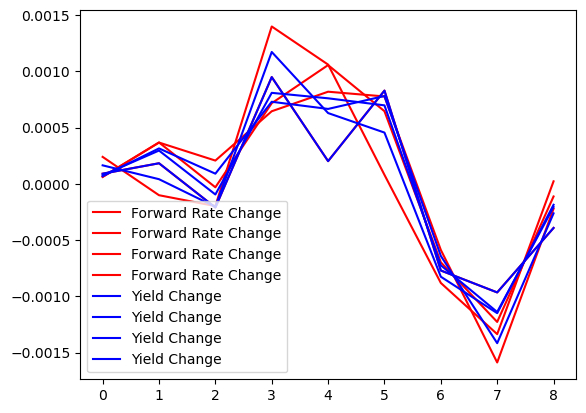

In [29]:
plt.figure()
plt.plot(forward_rate_array_diff, label='Forward Rate Change', color='r')
plt.plot(yield_rate_array_diff, label='Yield Change', color='b')
plt.legend()
plt.show()

Conduct Eigen-decomposition.

In [20]:
eigenvalues_forward, eigenvectors_forward = np.linalg.eig(forward_cov_matrix)
eigenvalues_yield, eigenvectors_yield = np.linalg.eig(yield_cov_matrix)

In [21]:
eigenvalues_forward

array([2.05347109e-06, 1.20431358e-07, 7.00849066e-08, 1.05563841e-08])

In [22]:
eigenvalues_yield

array([1.84064596e-06, 4.14919252e-08, 2.82961210e-08, 4.20747073e-09])

In [23]:
perc_forward = eigenvalues_forward[0] / eigenvalues_forward.sum()
perc_yield = eigenvalues_yield[0] / eigenvalues_yield.sum()
print(f"The first eigenvalue has can explains {round(perc_forward * 100, 2)}% of the variability in rate changes in forward rate")
print(f"The first eigenvalue has can explains {round(perc_yield * 100, 2)}% of the variability in rate changes in yield")

The first eigenvalue has can explains 91.08% of the variability in rate changes in forward rate
The first eigenvalue has can explains 96.14% of the variability in rate changes in yield


Note display the first eigenvector.

In [31]:
eigenvectors_forward[:, 0]

array([0.41966037, 0.55813193, 0.49282457, 0.51913183])

In [32]:
eigenvectors_yield[:, 0]

array([0.46536251, 0.51543649, 0.49531606, 0.52194345])